In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import filter_data 
import imp
# from pandasql import sqldf
# from progressbar import ProgressBar


imp.reload(filter_data)
pd.options.display.max_rows = 26
pd.options.display.max_columns = 99
import consts
imp.reload(consts)

ModuleNotFoundError: No module named 'filter_data'

In [2]:
df_inputs = pd.read_csv("filtered\\input_events_filtered_by_subject_id_and_medicine.csv")

In [9]:
unique_sids = df_inputs["subject_id"].unique()

In [155]:
def get_patient_noreadrenaline_tf(df, _subject_id, _stay_id):
    # if subject_id not in df["subject_id"].unique() or stay_id not in df["stay_id"].unique() or "Norepinephrine" not in df["itemid_label"].unique():
    #     return False
    return df[(df["subject_id"] == _subject_id) & (df["stay_id"] == _stay_id) & (df["itemid_label"] == "Norepinephrine")][["starttime", "endtime", "statusdescription", "originalrate", "itemid_label"]].sort_values(by="starttime")
    # return df[(df["subject_id"] == _subject_id) & (df["stay_id"] == _stay_id) & (df["itemid_label"] == "Norepinephrine")][["starttime", "endtime", "statusdescription", "originalrate", "itemid_label"]].sort_values(by="starttime")
    # return df[(df["subject_id"] == _subject_id) & (df["stay_id"] == _stay_id)][["starttime", "endtime", "statusdescription", "originalrate", "itemid_label"]].sort_values(by="starttime").copy()
    # return df[(df["subject_id"] == subject_id) & (df["stay_id"] == stay_id) & (df["itemid_label"] == "Norepinephrine")][["starttime", "endtime", "statusdescription", "originalrate"]].sort_values(by="starttime")
    

In [166]:
def count_overlaps(df, subject_id, stay_id):
    patient_noreadrenaline_tf = get_patient_noreadrenaline_tf(df, subject_id, stay_id)
    patient_inputs_without_ne = df[(df["subject_id"] == subject_id) & (df["stay_id"] == stay_id) & (df["itemid_label"] != "Norepinephrine")][["starttime", "endtime", "statusdescription", "originalrate"]].sort_values(by="starttime")
    counter = 0
    for event in patient_inputs_without_ne.itertuples():
        for noreadrenaline_event in patient_noreadrenaline_tf.itertuples():
            if event.starttime < noreadrenaline_event.endtime and event.endtime > noreadrenaline_event.starttime:
                counter += 1
    return counter

In [74]:
# create df with 3 columns
# overlaps_df = pd.DataFrame(columns=["subject_id", "stay_id", "overlaps"])
from tqdm import tqdm
import numpy as np

#sample n random unique subject_ids
random_sids = np.random.choice(unique_sids, size=2000, replace=False)
ls = []
for sid in tqdm(random_sids):
    stay_ids = df_inputs[df_inputs["subject_id"] == sid]["stay_id"].unique()
    for stay_id in stay_ids:
        ls.append({"subject_id": sid, "stay_id": stay_id, "overlaps": count_overlaps(df_inputs, sid, stay_id)})
overlaps_df = pd.DataFrame(ls)

100%|██████████| 2000/2000 [04:33<00:00,  7.30it/s]


<AxesSubplot:title={'center':'Amount of overlaps between recieving Norepinephrine\n and other inputs\n random 2000 subjects'}, xlabel='overlaps', ylabel='Count'>

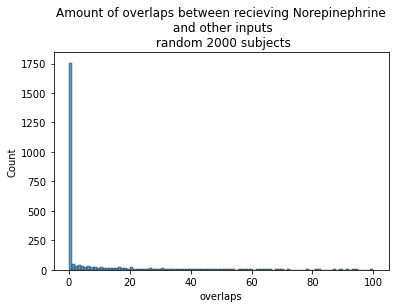

In [107]:
# plot overlaps
# set x limit to 100

# prctg of 0 overlaps
# overlaps_df[overlaps_df["overlaps"] == 0].shape[0] / ov
# erlaps_df.shape[0]
title = "Amount of overlaps between recieving Norepinephrine\n and other inputs\n random 2000 subjects"
plt.title(title)
sns.histplot(overlaps_df["overlaps"],binrange=[0,100])
# overlaps_df["overlaps"].value_counts()
# overlaps_df[overlaps_df["overlaps"] == 0].count() / random_sids.shape[0]

In [168]:
overlaps_df.to_csv("filtered\\overlaps_df.csv")

In [182]:
unique_stay_ids = df_inputs["stay_id"].unique()

In [222]:
def check_if_change_in_rate_greater_than_epsilon(stay_id, epsilon, status_description):
        input_for_patient = df_inputs[(df_inputs["stay_id"] == stay_id) & (df_inputs["statusdescription"] == status_description) &( df_inputs["itemid_label"] == "Norepinephrine")][["stay_id", "starttime", "endtime", "statusdescription", "originalrate", "rate", "itemid_label"]].sort_values(by="starttime")
        if input_for_patient.shape[0] == 0:
                return False
        previous_rate = input_for_patient.iloc[0]["originalrate"]
        previous_endtime = input_for_patient.iloc[0]["endtime"]
        for row in input_for_patient[1:].itertuples():
                if abs(row.originalrate - previous_rate) < epsilon and previous_endtime == row.starttime:
                        # print("stay_id: {}, status_description: {}, rate: {}, originalrate: {}, starttime: {}, endtime: {}".format(stay_id, status_description, row.rate, row.originalrate, row.starttime, row.endtime))
                        return True
                previous_rate = row.originalrate
                previous_endtime = row.endtime
        return False

random_stay_id = np.random.choice(unique_stay_ids, size=2000, replace=False)
ls = []
# for stay_id in tqdm(random_stay_id):
#         ls.append(check_if_change_in_rate_greater_than_epsilon(stay_id, 0.001, "ChangeDose/Rate"))

In [216]:
# sum(ls)
indices = [i for i, x in enumerate(ls) if x == True]

In [217]:
indices

[1055, 1152, 1256, 1267, 1343, 1685, 1700]

In [218]:
random_stay_id[1055]

37918933

In [224]:
check_if_change_in_rate_greater_than_epsilon(37918933, 0.001, "ChangeDose/Rate")

stay_id: 37918933, status_description: ChangeDose/Rate, rate: 0.1714181416900828, originalrate: 0.1689078360795974, starttime: 2178-09-02 08:08:00, endtime: 2178-09-02 08:11:00


True

In [206]:
indices = [i for i, x in enumerate(ls) if x == True]

In [223]:
df_inputs[(df_inputs["stay_id"] == 37918933) &( df_inputs["itemid_label"] == "Norepinephrine")][["stay_id", "starttime", "endtime", "statusdescription", "originalrate", "rate", "itemid_label"]].sort_values(by="starttime")

,stay_id,starttime,endtime,statusdescription,originalrate,rate,itemid_label
117325,37918933,2178-08-26 22:30:00,2178-08-26 22:49:00,ChangeDose/Rate,0.040000,0.040024,Norepinephrine
117334,37918933,2178-08-26 22:49:00,2178-08-26 23:59:00,ChangeDose/Rate,0.050000,0.050020,Norepinephrine
117360,37918933,2178-08-26 23:59:00,2178-08-27 03:16:00,ChangeDose/Rate,0.040000,0.040008,Norepinephrine
117372,37918933,2178-08-27 03:16:00,2178-08-27 05:00:00,ChangeDose/Rate,0.050000,0.049985,Norepinephrine
117331,37918933,2178-08-27 05:00:00,2178-08-27 05:37:00,ChangeDose/Rate,0.060000,0.060016,Norepinephrine
117392,37918933,2178-08-27 05:37:00,2178-08-27 07:38:00,ChangeDose/Rate,0.070000,0.070062,Norepinephrine
117423,37918933,2178-08-27 07:38:00,2178-08-27 08:16:00,ChangeDose/Rate,0.080000,0.080103,Norepinephrine
117382,37918933,2178-08-27 08:16:00,2178-08-27 08:53:00,ChangeDose/Rate,0.070000,0.070188,Norepinephrine
117349,37918933,2178-08-27 08:53:00,2178-08-27 10:29:00,ChangeDose/Rate,0.060000,0.060161,Norepinephrine
117399,37918933,2178-08-27 10:29:00,2178-08-27 11:21:00,ChangeDose/Rate,0.050000,0.050096,Norepinephrine
